# Kernelized Support Vector Machines

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap
import seaborn as sns
import pandas as pd

from sklearn.datasets import make_blobs, load_breast_cancer, make_moons
from sklearn.metrics import euclidean_distances
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.utils import Bunch

from mpl_toolkits.mplot3d import Axes3D, axes3d

In [3]:
def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    # Define colors for each category
    palete = plt.get_cmap('bwr')
    color_cycle = [palete(0.0), palete(1.0)]  # Define specific colors

    # Handle the case where there is only one unique value
    if len(unique_y) == 1:
        single_color = color_cycle[0] if unique_y[0] == 0 else color_cycle[1]
        color_cycle = [single_color] * len(unique_y)

    for i, (yy, color) in enumerate(zip(unique_y, color_cycle)):
        mask = y == yy
        if c is None:
            current_color = color
        elif len(c) > 1:
            current_color = c[i]
        else:
            current_color = c
        
        if np.mean(colorConverter.to_rgb(current_color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, color=current_color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines

In [4]:
def plot_2d_separator(classifier, X, fill=False, ax=None, eps=None, alpha=1,                      
                        cm=None, linewidth=None, threshold=None, linestyle="solid"):
    if cm is None:
        cm = ListedColormap(['#0000aa', '#ff2020'])
    
    # binary?
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0] if threshold is None else [threshold]
        fill_levels = [decision_values.min()] + levels + [
            decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5] if threshold is None else [threshold]
        fill_levels = [0] + levels + [1]
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
                    levels=fill_levels, alpha=alpha, cmap=cm)
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black", alpha=alpha, linewidths=linewidth,
                   linestyles=linestyle, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


Text(0, 0.5, 'Feature 1')

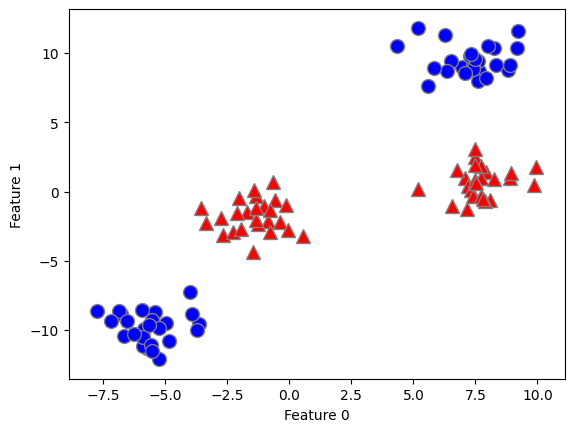

In [5]:
X, y = make_blobs(centers=4, random_state=8)
y = y % 2

discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0, 0.5, 'Feature 1')

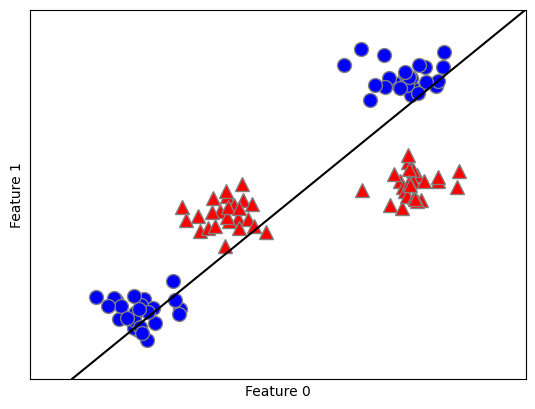

In [6]:
linear_svm = LinearSVC().fit(X, y)

plot_2d_separator(linear_svm, X)
discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

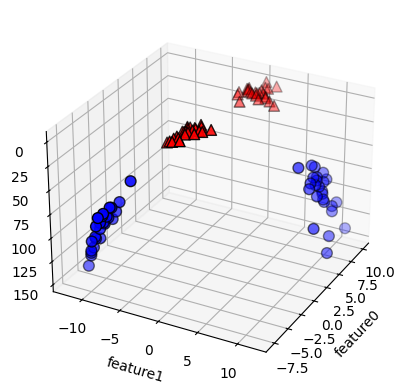

In [7]:
# add the squared first feature
X_new = np.hstack([X, X[:, 1:] ** 2])

figure = plt.figure()
# visualize in 3D
ax = figure.add_subplot(111, projection='3d', elev=-152, azim=-28)
# plot first all the points with y==0, then all with y == 1
cm2 = ListedColormap(['#0000aa', '#ff2020'])
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',  s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', s=60, edgecolor='k')
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")
plt.show()


Text(0.5, 0, 'feature1 ** 2')

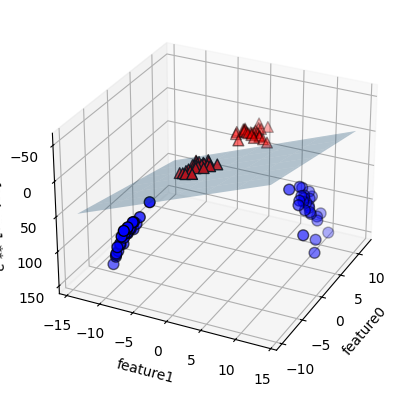

In [8]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# show linear decision boundary
figure = plt.figure()
ax = figure.add_subplot(111, projection='3d', elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
            s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
            s=60, edgecolor='k')

ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

Text(0, 0.5, 'Feature 1')

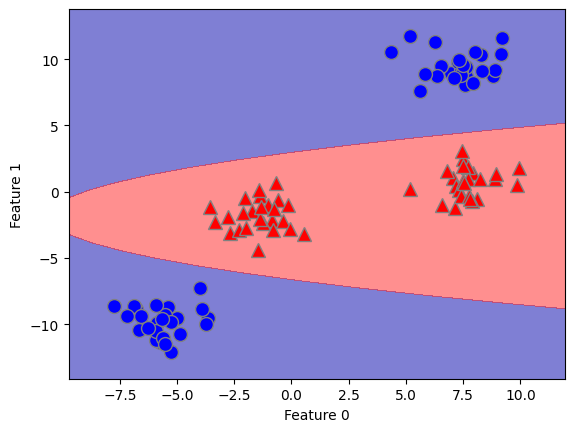

In [9]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=cm2, alpha=0.5)
discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0, 0.5, 'Feature 1')

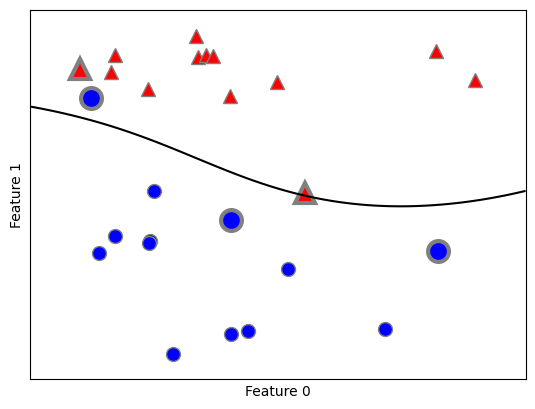

In [10]:
X, y = make_blobs(centers=2, random_state=4, n_samples=30)
y[np.array([7, 27])] = 0
mask = np.ones(len(X), dtype=bool)
mask[np.array([0, 1, 5, 26])] = 0
X, y = X[mask], y[mask]   

svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
plot_2d_separator(svm, X, eps=.5)
discrete_scatter(X[:, 0], X[:, 1], y)
# plot support vectors
sv = svm.support_vectors_
# class labels of support vectors are given by the sign of the dual coefficients
sv_labels = svm.dual_coef_.ravel() > 0
discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [11]:
def plot_svm(log_C, log_gamma, ax=None):
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]  

    C = 10. ** log_C
    gamma = 10. ** log_gamma
    svm = SVC(kernel='rbf', C=C, gamma=gamma).fit(X, y)
    if ax is None:
        ax = plt.gca()
    plot_2d_separator(svm, X, ax=ax, eps=.5)
    # plot data
    discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    # plot support vectors
    sv = svm.support_vectors_
    # class labels of support vectors are given by the sign of the dual coefficients
    sv_labels = svm.dual_coef_.ravel() > 0
    discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3, ax=ax)
    ax.set_title("C = %.4f gamma = %.4f" % (C, gamma))

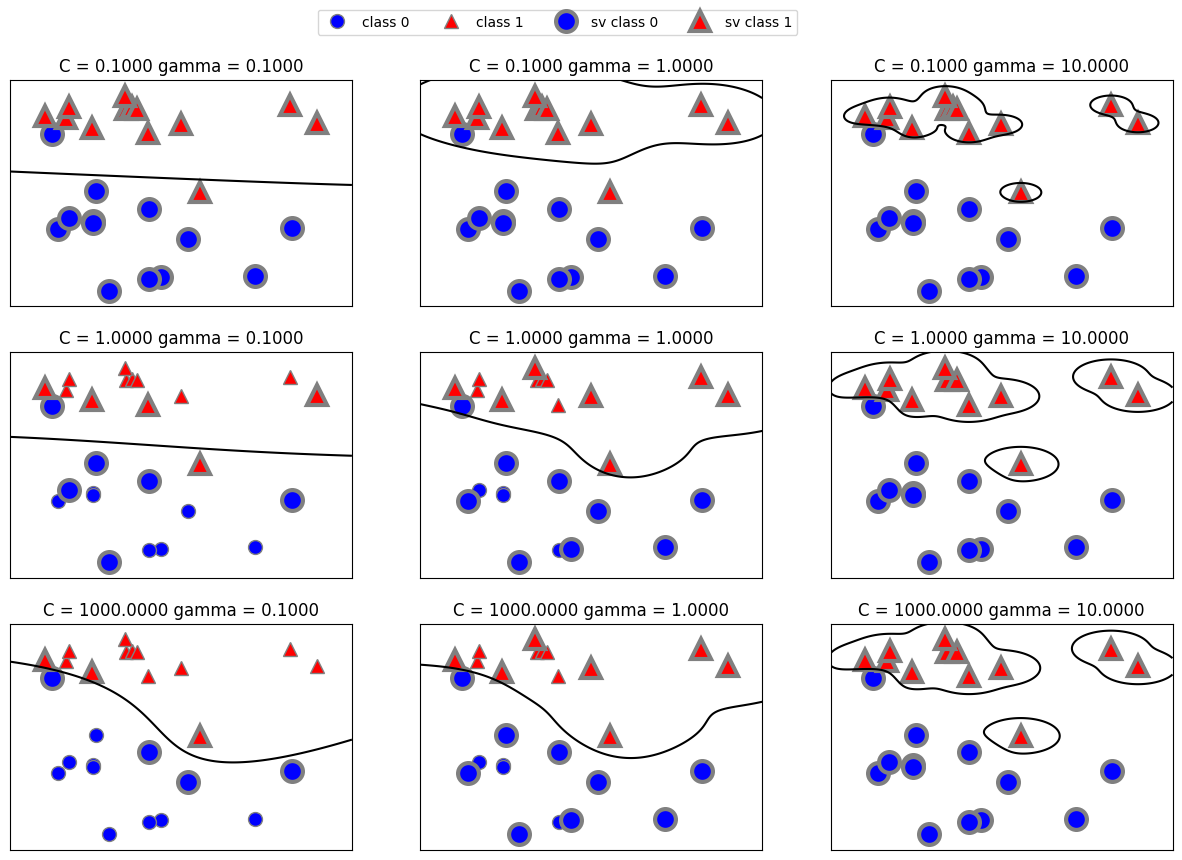

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"],
                  ncol=4, loc=(.9, 1.2))

In [13]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.90
Accuracy on test set: 0.94


Text(0, 0.5, 'Feature magnitude')

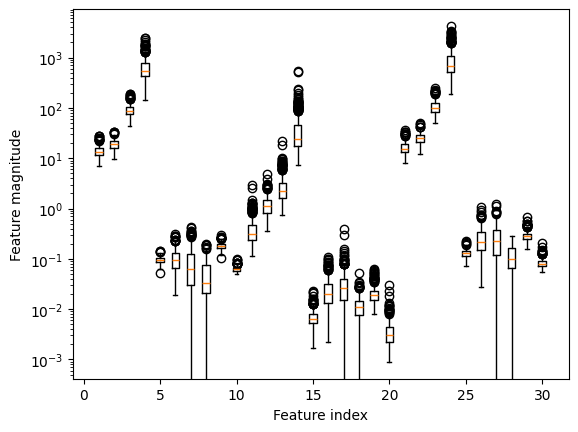

In [21]:
plt.boxplot(X_train, manage_ticks=False)
plt.yscale("log")
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")

Text(0, 0.5, 'Feature magnitude')

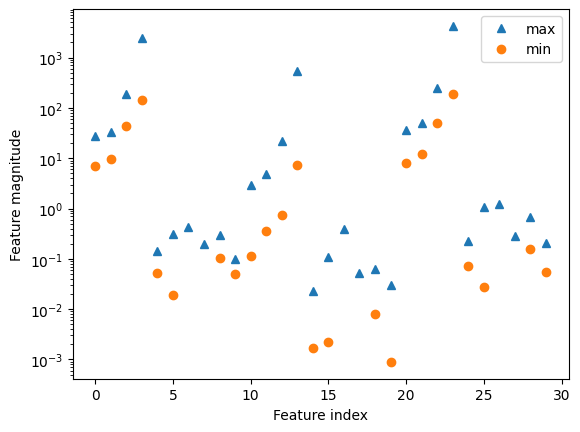

In [29]:
plt.plot(X_train.max(axis=0), '^', label='max')
plt.plot(X_train.min(axis=0), 'o', label='min')
plt.legend(loc='best')
plt.yscale("log")
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")

In [15]:
# Compute the minimum value per feature on the training set
min_on_training = X_train.min(axis=0)
# Compute the range of each feature (max - min) on the training set
range_on_training = (X_train - min_on_training).max(axis=0)

# subtract the min, divide by range
# afterward, min=0 and max=1 for each feature
X_train_scaled = (X_train - min_on_training) / range_on_training
print("Minimum for each feature\n", X_train_scaled.min(axis=0))
print("Maximum for each feature\n", X_train_scaled.max(axis=0))

Minimum for each feature
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Maximum for each feature
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


Text(0, 0.5, 'Feature magnitude')

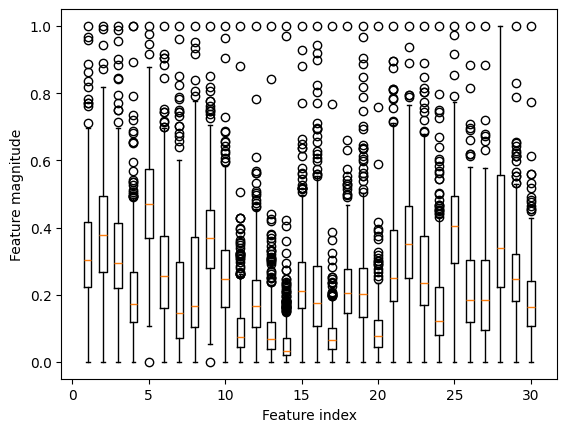

In [31]:
plt.boxplot(X_train_scaled, manage_ticks=False)
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")

In [16]:
# use THE SAME transformation on the test set,
# using min and range of the training set. See Chapter 3 (unsupervised learning) for details.
X_test_scaled = (X_test - min_on_training) / range_on_training

In [18]:
svc = SVC()
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
        svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.984
Accuracy on test set: 0.972


In [19]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
    svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.958
